<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/CNN_pixel_segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN for Pixel segmentation**

In [ ]:
# !pip install -r requirements.txt

In [1]:
# Importing Libraries
import zipfile
import os
from PIL import Image
import numpy as np
from skimage import img_as_ubyte
from scipy.spatial.distance import cdist
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Softmax
import matplotlib.pyplot as plt

# Unzipping and Defining Directories

*   train image
      * image1
      * image2 ...
*   train mask image
      * mask1
      * mask2 ...
*   test image
      * test_image
*   test mask image
      * test_mask


In [2]:
# Unzipping and Defining Directories
zip_path = '/content/data.zip'
unzip_dir = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
data_dir = os.path.join(unzip_dir, 'data')
# train_dir = os.path.join(data_dir, 'train')
# masks_dir = os.path.join(data_dir, 'masks')
# test_dir = os.path.join(data_dir, 'test')
# test_masks_dir = os.path.join(data_dir, 'test_mask')

# Mapping of RGB Colors to Class Labels and Conversion Function

In [3]:
# Mapping of RGB colors to class labels
class_colors = np.array([
    [0, 0, 0],    # Black
    [255, 0, 0],  # Red
    [0, 255, 0],  # Green
    [0, 0, 255]   # Blue
])

# Function to convert mask image to class labels
def convert_mask_to_labels(mask_image):
    display(mask_image.shape)
    mask_labels = np.zeros(mask_image.shape[:2], dtype=np.uint8)
    mask_image = mask_image[:, :, :3]
    for i in range(mask_image.shape[0]):
        for j in range(mask_image.shape[1]):
            distances = cdist([mask_image[i, j]], class_colors, 'euclidean')
            class_label = np.argmin(distances)
            mask_labels[i, j] = class_label  ## the output example class_label 0 class_label 0 class_label 0
    return mask_labels

# Loading Images and Masks

In [4]:
# Loading images and masks
def load_images_and_masks(image_dir, mask_dir, is_test=False):
    images = []
    masks = []
    for image_name in tqdm(os.listdir(image_dir)):
      print(image_name)
      image_path = os.path.join(image_dir, image_name)
      if image_path != '/content/data/train/.ipynb_checkpoints' and  image_path != '/content/data/test/.ipynb_checkpoints':
        mask_name = "test_mask.JPG" if is_test else "mask" + image_name[5:]
        mask_path = os.path.join(mask_dir, mask_name)

        # Load image and mask
        image = Image.open(image_path)
        mask_image = Image.open(mask_path)

        # Convert mask image to class labels
        mask_labels = convert_mask_to_labels(np.array(mask_image))
        images.append(img_as_ubyte(image))
        masks.append(mask_labels)

    return np.array(images), np.array(masks)

train_dir = "/content/data/train"
masks_dir = "/content/data/masks"
test_dir = "/content/data/test"
test_masks_dir = "/content/data/test_mask"


# Loading Training and Test Datasets

In [5]:
qwe = np.array(Image.open("/content/data/masks/mask1.JPG"))
qwe.shape

(990, 1060, 4)

In [6]:
qwe = np.array(Image.open("/content/data/masks/mask1.JPG"))
qwe.shape

(990, 1060, 4)

In [7]:
# Loading training and test datasets
train_images, train_masks = load_images_and_masks(train_dir, masks_dir)
test_images, test_masks = load_images_and_masks(test_dir, test_masks_dir, is_test=True)

  0%|          | 0/2 [00:00<?, ?it/s]

image1.JPG


(990, 1060, 4)

 50%|█████     | 1/2 [00:10<00:10, 10.36s/it]

image2.JPG


(990, 1060, 4)

  0%|          | 0/1 [00:00<?, ?it/s]

test_image.JPG


(990, 1060, 4)

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


In [8]:
add_colors = lambda x: class_colors[x].astype(dtype=np.uint8)

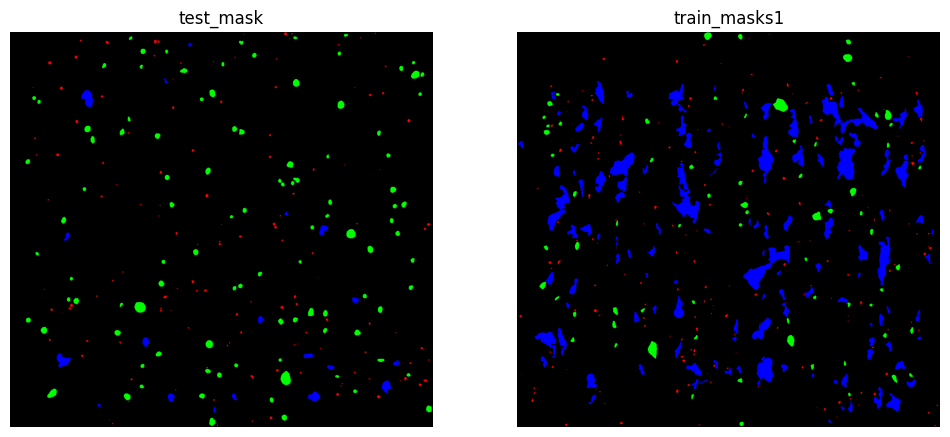

In [9]:
# Plotting Original and Predicted Images
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].imshow(add_colors(test_masks[0]))
ax[0].set_title("test_mask")
ax[0].axis('off')

ax[1].imshow(add_colors(train_masks[0]))
ax[1].set_title("train_masks1")
ax[1].axis('off')
# ax[2].imshow(train_masks[1])
# ax[2].set_title("train_masks2")
# ax[2].axis('off')
plt.show()

# Building the CNN Model

# Reshaping Masks for Training and Training the Model

In [10]:
def normalize(x):
    # Please note that there is the similar function in Sklearn also
    return (x-np.min(x))/(np.max(x)-np.min(x))

Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 1.3832 - accuracy: 0.9400
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 1.3803 - accuracy: 0.9406
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 1.3776 - accuracy: 0.9408
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 1.3749 - accuracy: 0.9411
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 1.3721 - accuracy: 0.9412


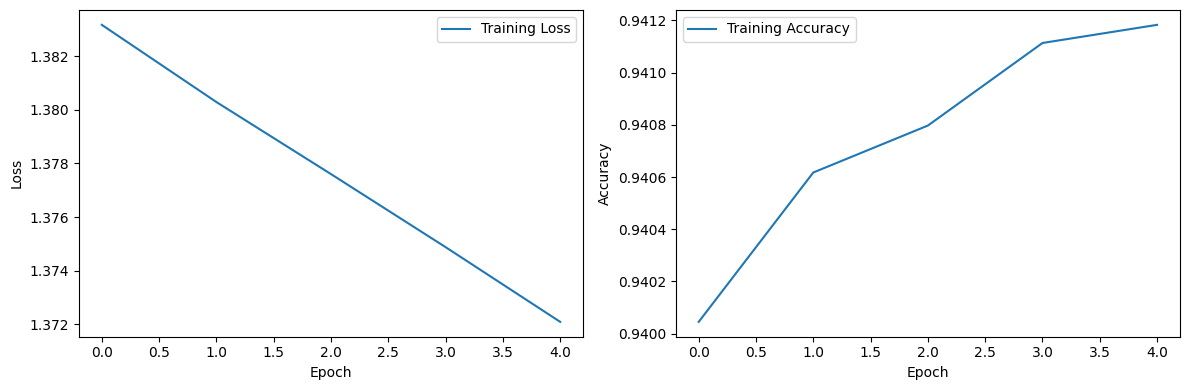

1/1 [==============================] - 1s 1s/step
Accuracy for Class 0: 99.00%
Accuracy for Class 1: 0.25%
Accuracy for Class 2: 6.73%
Accuracy for Class 3: 6.41%


In [17]:
import numpy as np
import cv2
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import metrics


# # Custom Softmax Function at Pixel Level
# def pixelwise_softmax(x):
#     e = K.exp(x - K.max(x, axis=-1, keepdims=True))
#     s = K.sum(e, axis=-1, keepdims=True)
#     return e / s
####  train_images, train_masks
# Updated function to build the CNN model
def build_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(4, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2DTranspose(4, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        Conv2DTranspose(4, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        Conv2D(num_classes, (3, 3), padding='same'),
        # Activation(pixelwise_softmax)  # Applying custom softmax activation
        Activation('softmax')
    ])

    return model

# #####  train_images, train_masks
# # Updated function to build the CNN model
# def build_simple_cnn(input_shape, num_classes):
#     model = Sequential([
#         Conv2D(4, (2, 2), activation='relu', padding='same', input_shape=input_shape),
#         MaxPooling2D((2, 2), padding='same'),
#         Conv2D(4, (2, 2), activation='relu', padding='same'),
#         MaxPooling2D((2, 2), padding='same'),
#         Conv2D(4, (2, 2), activation='relu', padding='same'),
#         MaxPooling2D((2, 2), padding='same'),
#         Conv2DTranspose(4, (2, 2), activation='relu', padding='same', strides=(2, 2)),
#         Conv2DTranspose(4, (2, 2), activation='relu', padding='same', strides=(2, 2)),
#         Conv2DTranspose(4, (2, 2), activation='relu', padding='same', strides=(2, 2)),
#         Conv2D(num_classes, (2, 2), padding='same'),
#         # Activation(pixelwise_softmax)  # Applying custom softmax activation
#         Activation('softmax')
#     ])

#     return model

# # Updated function to build the CNN model
# TODO: It's for image classification only.
# def build_simple_cnn(input_shape, num_classes):
#   model = Sequential()
#   model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(128, 128, 3)))
#   model.add(MaxPooling2D((2, 2)))
#   model.add(Conv2D(4, (3, 3), activation='relu'))
#   model.add(MaxPooling2D((2, 2)))
#   model.add(Flatten())
#   model.add(Dense(num_classes))
#   model.add(Softmax())
#   return model

# Define your input shape and number of classes
# input_shape = (1024, 1024, 3)
input_shape = (992, 1060, 3)
num_classes = 4

# Build and compile the corrected model
simple_cnn_model = build_simple_cnn(input_shape, num_classes)
simple_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resize the data to match the input dimensions of the model
desired_shape = (1060, 992)  # Adjust the shape for resizing
resized_train_images = np.array([cv2.resize(img, desired_shape) for img in train_images])
resized_train_masks = np.array([cv2.resize(mask, desired_shape) for mask in train_masks])

# Training the Model
history = simple_cnn_model.fit(resized_train_images, resized_train_masks, epochs=5)

# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Calculate accuracy per class
class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]
predictions = simple_cnn_model.predict(resized_train_images)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = resized_train_masks
for i, class_name in enumerate(class_names):
    class_mask = (true_labels == i)
    class_accuracy = np.mean(predicted_labels[class_mask] == true_labels[class_mask])
    print(f"Accuracy for {class_name}: {class_accuracy * 100:.2f}%")

In [18]:
simple_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 992, 1060, 4)      112       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 496, 530, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 496, 530, 4)       148       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 248, 265, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 496, 530, 4)      148       
 Transpose)                                                      
                                                      

# Predicting on Train Data

1/1 [==============================] - 2s 2s/step
train_predictions (2, 992, 1060, 4)
Train Accuracy: 94.38%, IoU: 2.89%
1/1 [==============================] - 2s 2s/step
Accuracy for Class 0: 98.99%
Accuracy for Class 1: 0.04%
Accuracy for Class 2: 6.82%
Accuracy for Class 3: 6.22%


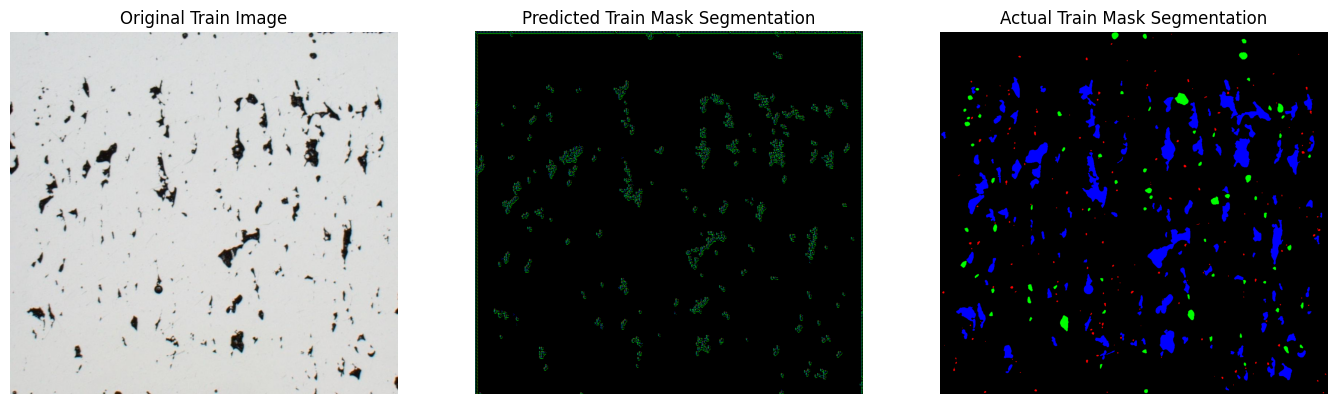

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import metrics

### train_images, train_masks
desired_shape = (1060, 992)  # Adjust the shape for resizing
resized_train_images = np.array([cv2.resize(img, desired_shape) for img in train_images])

# Predict on the resized train images
train_predictions = simple_cnn_model.predict(resized_train_images)
print('train_predictions', train_predictions.shape)
# # Get the class with the highest probability for each pixel
train_predictions = np.argmax(train_predictions, axis=-1)

# # Reshape predictions to match original image shape
train_predictions = train_predictions.reshape(resized_train_images.shape[0], *resized_train_images.shape[1:3])

# # Resizing the train masks to match the predictions
resized_train_masks = np.array([cv2.resize(mask, desired_shape, interpolation=cv2.INTER_NEAREST) for mask in train_masks])

# # Flattening the predictions and the true masks
flat_predictions = train_predictions.flatten()
flat_true_masks = resized_train_masks.flatten()

# # Calculating the accuracy
accuracy = np.sum(flat_predictions == flat_true_masks) / flat_predictions.size

# # Calculating the intersec over union
m_iou = metrics.IoU(num_classes=4, target_class_ids=[1, 2, 3])
m_iou.update_state(y_true=resized_train_masks, y_pred=train_predictions)
iou = m_iou.result().numpy()

print(f"Train Accuracy: {accuracy * 100:.2f}%, IoU: {iou*100:.2f}%")

# Calculate accuracy per class
class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]
predictions = simple_cnn_model.predict(resized_train_images)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = resized_train_masks
for i, class_name in enumerate(class_names):
    class_mask = (true_labels == i)
    class_accuracy = np.mean(predicted_labels[class_mask] == true_labels[class_mask])
    print(f"Accuracy for {class_name}: {class_accuracy * 100:.2f}%")

# Plotting Original and Predicted Images
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
ax[0].imshow(train_images[0])
ax[0].set_title("Original Train Image")
ax[0].axis('off')

ax[1].imshow(add_colors(train_predictions[0]))
ax[1].set_title("Predicted Train Mask Segmentation")
ax[1].axis('off')

ax[2].imshow(add_colors(train_masks[0]))
ax[2].set_title("Actual Train Mask Segmentation")
ax[2].axis('off')
plt.show()




In [23]:
uniques, counts = np.unique(resized_test_masks, return_counts=True)
unique_count = {unique:count for unique, count in zip(uniques, counts)}
print('pixel count & % in each class::')
display(unique_count)

unique_count_percent = {unique:count/resized_test_masks.reshape(-1).shape[0] for unique, count in zip(uniques, counts)}
display(unique_count_percent)


pixel count & % in each class::


{0: 1030008, 1: 2584, 2: 13941, 3: 4987}

{0: 0.9795419963481437,
 1: 0.002457395009129641,
 2: 0.013257950395617772,
 3: 0.004742658247108947}

# Predicting on Test Data

1/1 [==============================] - 1s 1s/step
Test Accuracy: 97.24%, IoU: 0.02%
1/1 [==============================] - 1s 819ms/step
Accuracy for Class 0: 99.17%
Accuracy for Class 1: 0.08%
Accuracy for Class 2: 6.23%
Accuracy for Class 3: 4.13%


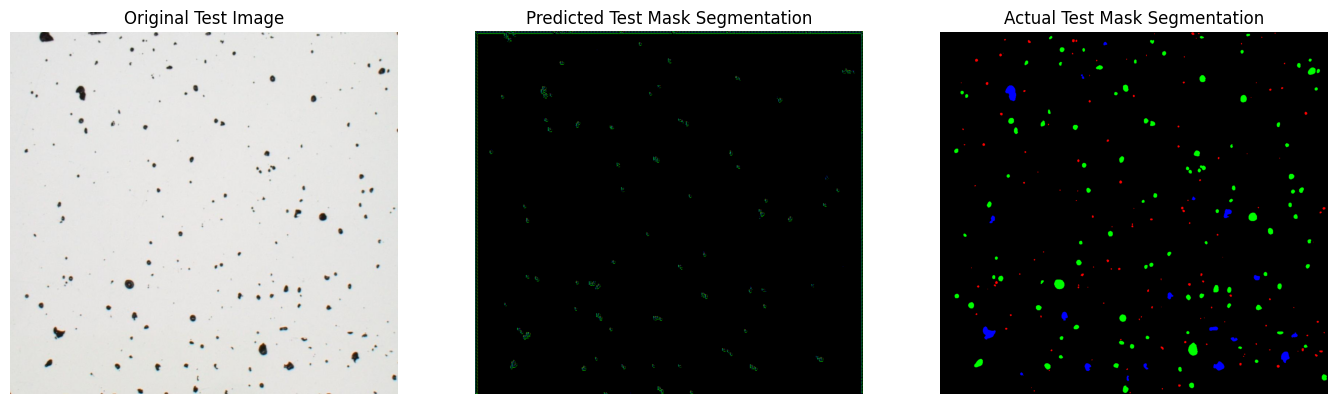

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import metrics

### test_images, test_masks
# Resize the test images to match the input dimensions of the model
desired_shape = (1060, 992)  # Adjust the shape for resizing
resized_test_images = np.array([cv2.resize(img, desired_shape) for img in test_images])

# Predict on the resized test images
test_predictions = simple_cnn_model.predict(resized_test_images)

# # Get the class with the highest probability for each pixel
test_predictions = np.argmax(test_predictions, axis=-1)

# # Reshape predictions to match original image shape
test_predictions = test_predictions.reshape(resized_test_images.shape[0], *resized_test_images.shape[1:3])

# # Resizing the test masks to match the predictions
resized_test_masks = np.array([cv2.resize(mask, desired_shape, interpolation=cv2.INTER_NEAREST) for mask in test_masks])

# # Flattening the predictions and the true masks
flat_predictions = test_predictions.flatten()
flat_true_masks = resized_test_masks.flatten()

# # Calculating the accuracy
accuracy = np.sum(flat_predictions == flat_true_masks) / flat_predictions.size

# # Calculating the intersec over union
m_iou = metrics.IoU(num_classes=4, target_class_ids=[1, 2, 3])
m_iou.update_state(y_true=resized_test_masks, y_pred=test_predictions)
iou = m_iou.result().numpy()

print(f"Test Accuracy: {accuracy * 100:.2f}%, IoU: {iou:.2f}%")

# Calculate accuracy per class
class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]
predictions = simple_cnn_model.predict(resized_test_images)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = resized_test_masks
for i, class_name in enumerate(class_names):
    class_mask = (true_labels == i)
    class_accuracy = np.mean(predicted_labels[class_mask] == true_labels[class_mask])
    print(f"Accuracy for {class_name}: {class_accuracy * 100:.2f}%")

# Plotting Original and Predicted Images
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
ax[0].imshow(test_images[0])
ax[0].set_title("Original Test Image")
ax[0].axis('off')

ax[1].imshow(add_colors(test_predictions[0]))
ax[1].set_title("Predicted Test Mask Segmentation")
ax[1].axis('off')

ax[2].imshow(add_colors(test_masks[0]))
ax[2].set_title("Actual Test Mask Segmentation")
ax[2].axis('off')
plt.show()



In [25]:
print("Shape of train_images:", train_images.shape)
print("Shape of train_masks_reshaped:", train_masks.shape)

# Print model summary
simple_cnn_model.summary()


Shape of train_images: (2, 990, 1060, 3)
Shape of train_masks_reshaped: (2, 990, 1060)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 992, 1060, 4)      112       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 496, 530, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 496, 530, 4)       148       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 248, 265, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 496, 530, 4)      148       
 Transpose)                      

# the following code to download the results and check the colors of the masks

In [75]:
from google.colab import files
!zip -r /content/data.zip /content/data
files.download('/content/data.zip')


  adding: content/data/ (stored 0%)
  adding: content/data/train/ (stored 0%)
  adding: content/data/train/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/train/image1.JPG (deflated 1%)
  adding: content/data/test_mask/ (stored 0%)
  adding: content/data/test_mask/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/test_mask/test_mask.JPG (deflated 12%)
  adding: content/data/test/ (stored 0%)
  adding: content/data/test/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/test/test_image.JPG (deflated 4%)
  adding: content/data/masks/ (stored 0%)
  adding: content/data/masks/mask1.JPG (deflated 3%)
  adding: content/data/masks/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# img_temp = Image.open(image_path)
from PIL import Image
import numpy as np
import cv2
img_temp = Image.open('/content/data/masks/mask2.JPG')
np.unique(np.array(img_temp))

array([  0, 255], dtype=uint8)

In [19]:
# image = cv2.imread(image_path)
image = cv2.imread(('/content/data/masks/mask2.JPG'))
np.unique(image)

array([  0, 255], dtype=uint8)

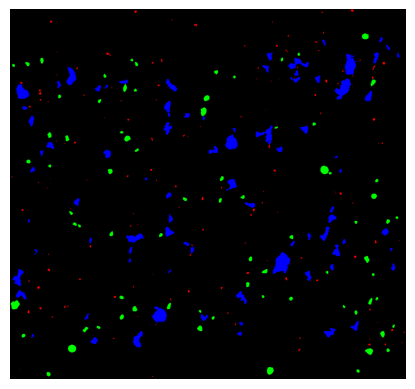

Image Information:
Height: 990
Width: 1060
Channels: 3
Pixel Values in ROI:
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0

In [20]:
import cv2
import matplotlib.pyplot as plt

# Load the image using OpenCV
image_path = '/content/data/masks/mask2.JPG'  # Replace with the actual path to your image
image = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Check if the image was loaded successfully
if image is None:
    print("Error: Unable to load image.")
else:
    # Get image dimensions (height, width, number of channels)
    height, width, channels = image.shape

    print("Image Information:")
    print("Height:", height)
    print("Width:", width)
    print("Channels:", channels)

    # Choose a region of interest (ROI) within the image
    # Define the coordinates of the top-left and bottom-right corners of the ROI
    roi_top_left = (100, 100)  # Replace with your desired coordinates
    roi_bottom_right = (200, 200)  # Replace with your desired coordinates

    # Extract the ROI from the image
    roi = image[roi_top_left[1]:roi_bottom_right[1], roi_top_left[0]:roi_bottom_right[0]]

    # Print pixel values of the ROI
    print("Pixel Values in ROI:")
    for row in roi:
        print(row)